<a href="https://colab.research.google.com/github/eischaire/Distributional-Model-for-Semantic-Disambiguation/blob/master/Distributional_Similarity_Heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations; imports; assignments of imported preprocessing tools

In [2]:
!pip install pymorphy2

In [3]:
import re
import os
import json
import pymorphy2
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from math import sqrt
# from __future__ import print_function
import time 
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from tqdm import tqdm
# import networkx as nx
# from networkx.readwrite import json_graph

nltk.download('stopwords')
stop_words = stopwords.words('russian')

lem = pymorphy2.MorphAnalyzer()

sns.set(rc={'figure.facecolor': 'white'})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collecting texts to /content

In [0]:
# !wget http://lib.ru/DOWLATOW/kompromiss.txt
# !wget http://lib.ru/RBACH/award.txt
# !wget http://lib.ru/PRIKL/PSHIMANOWSKIJ/pancerni.txt
# !wget http://lib.ru/WELLER/dovlatov.txt
# !wget http://lib.ru/PROZA/ORLOW_O/nikolsk.txt
# !wget http://lib.ru/NEWPROZA/RUBINA/venice.txt
# !wget http://lib.ru/PROZA/DOMBROWSKIJ/faculty.txt
# !wget http://lib.ru/DYACHENKO/r_hk.txt

## Preprocessing functions

In [0]:
def read_file(path, enc):
  """
  Extracts a text from a file that is found by a given path.

  :path: str
  :enc: str, file encoding

  :output: str, raw text from the file
  """
  with open(path, 'r', encoding=enc) as f:
    text = f.read()
  
  return text

In [0]:
def clean_text(text, tags_in_text=True):
  """
  Cleans raw text from brackets, tags, and extra characters.
  Returns the cleaned text in lowercase.

  :text: str
  :tags_in_text: bool, whether html tags occur in the raw text
  
  :output: str, lowercase cleaned text
  """
  text = re.sub('\r\n', '\n', text)
  if tags_in_text == True:
    text = re.sub('\[.+?\]\n?', '', text)
    text = re.sub('\<.+?\>', '', text, flags=re.DOTALL)
    text = re.sub('\&.+?; ?', '', text)
  text = re.sub('(\n +?)+', '\n', text)
  text = re.sub('(\n +)+', ' ', text)
  text = re.sub('\n', ' ', text)
  text = text.lower()

  return text

In [0]:
def lemmatize(text, remove_stopwords=False):
  """
  Returns a list of lemmas in the order of their occurrence in the text.

  :text: str

  :output: list, lemmatized words from the text
  """
  words = re.findall('([а-я1-9]+)', text)
  lemmas = [lem.parse(word)[0].normal_form for word in words]
  if remove_stopwords == True:
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words]
  return lemmas

In [0]:
from collections import Counter

In [0]:
def collocations(lemma_lists, min_count=5):
  """
  Makes a dictionary of frequently occurring collocations from the whole corpus
  and their occurrence counts.

  :lemma_lists: list of lists of lemmas from each document in a corpus
  :min_count: int, minimum collocation occurrence count 
  to be accommodated in the model

  :output: dict of dicts, frequent collocation counts in a corpus
  """
  word_corpus = [lemma for l_list in lemma_lists for lemma in l_list]
  word_counts = Counter(word_corpus)
  lemmas_colloc = {}
  for lemmas in lemma_lists:
    for i in range(len(lemmas)):
      if lemmas[i] not in lemmas_colloc:
        lemmas_colloc[lemmas[i]] = defaultdict(int)
      for j in range(-5,6):
        if i+j >= 0 and j != 0 and i+j < len(lemmas):
          # if word_counts[lemmas[i+j]] >= min_count:
          lemmas_colloc[lemmas[i]][lemmas[i+j]] += 1

  frequent_colloc = defaultdict(dict)
  # frequent_colloc = {}
  for coll in lemmas_colloc:
    # frequent_colloc[coll] = {}
    for sec in lemmas_colloc[coll]:
      if lemmas_colloc[coll][sec] >= min_count:
        frequent_colloc[coll][sec] = lemmas_colloc[coll][sec]

  return dict(frequent_colloc)

In [0]:
def extract_lemma_list(path, encoding, tags_in_text=True, remove_stopwords=False):
  """
  Extracts text from the file found by a given path, and 
  makes a list of lemmatized words in the order of their
  occurrence in the text. 

  :path: str
  :encoding: str
  :tags_in_text: bool
  :remove_stopwords: bool

  :output: list of lemmas
  """
  raw = read_file(path, encoding)
  text = clean_text(raw, tags_in_text)
  lemma_list = lemmatize(text, remove_stopwords)
  
  return lemma_list

In [0]:
def extend_corpus(path_list, encoding_list, tagged_list, remove_stopwords=False, corpus=[]):
  """

  :path_list: list of strings. each element is a path for a file
  :encoding_list: list of strings. encoding_list[i] is the encoding of the file found by path_list[i]
  :tagged_list: list of bools. tagged_list[i] shows whether html tags occur in the text in path_list[i]
  :remove_stopwords: bool
  :corpus: list of lists of lemmas if other documents were already added to the corpus

  :output: list of lists of lemmas, the extended corpus

  """
  for i in range(len(path_list)):
    path = path_list[i]
    enc = encoding_list[i]
    tags = tagged_list[i]
    lemma_list = extract_lemma_list(path, enc, tags, remove_stopwords)
    corpus.append(lemma_list)
  return corpus

## preprocessing

In [0]:
lemma_lists = []

In [0]:
path_list = ['dovlatov (1).txt', 'kompromiss.txt', 'nikolsk (1).txt', 'award.txt', 'venice.txt', 'faculty.txt', 'pancerni.txt', 'r_hk.txt']
enc_list = ['koi8-r'] * 8
tagged = [True] * 8
lemma_lists = extend_corpus(path_list, enc_list, tagged, remove_stopwords=True, corpus=[])

In [0]:
from collections import Counter
full_corp = [lemma for llist in lemma_lists for lemma in llist]
lemma_count = Counter(full_corp)

## building word co-occurrence frequency dictionary

In [0]:
freq_colloc = collocations(lemma_lists, min_count=1)

In [17]:
len(freq_colloc)

30204

In [18]:
min_len = 100500
for word in freq_colloc:
  coll_len = len(freq_colloc[word])
  if coll_len < min_len:
    min_len = coll_len
print('minimal length of neighbor list for one word is', min_len)

minimal length of neighbor list for one word is 4


## building vectors

In [0]:
pilot_colloc = {}
for key in freq_colloc:
  pilot_colloc[key] = list(freq_colloc[key].keys())

In [0]:
dims = set([word for item in list(pilot_colloc.values()) for word in item])

In [80]:
print(len(dims))

30204


In [25]:
try:
  for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)
except Exception:
  pass


vec_dic = {}
for key in tqdm(freq_colloc):
  vec = []
  for word in dims:
    val = 0
    if word in freq_colloc[key]:
      val = freq_colloc[key][word]
    vec.append(val)
  vec_dic[key] = vec

100%|██████████| 30204/30204 [04:32<00:00, 111.02it/s]


## finding test words in the model vocabulary

In [0]:
with open('colors_oneword.txt', 'r', encoding='utf-8') as f:
  one_word_colors = [word.strip('\n').lower() for word in f.readlines()]

with open('materials.txt', 'r', encoding='utf-8') as f:
  mat = [word.strip('\n').lower() for word in f.readlines()]

with open('ingredients.txt', 'r', encoding='utf-8') as f:
  ing = [word.strip('\n').lower() for word in f.readlines()]

In [27]:
corpus_color = {}
for word in one_word_colors:
  if word in vec_dic:
    corpus_color[word] = vec_dic[word]
print('corpus_color:', len(corpus_color))

corpus_mat = {}
for word in mat:
  if word in vec_dic:
    corpus_mat[word] = vec_dic[word]
print('corpus_mat:', len(corpus_mat))

corpus_ing = {}
for word in ing:
  if word in vec_dic:
    corpus_ing[word] = vec_dic[word]
print('corpus_ing:', len(corpus_ing))

corpus_color: 58
corpus_mat: 56
corpus_ing: 31


In [28]:
var1 = sorted(corpus_color.keys())
var2 = sorted(corpus_mat.keys())
var3 = sorted(corpus_ing.keys())

corp_col_mat = []
for word in var1:
  if word in var2:
    corp_col_mat.append(word)

corp_col_ing = []
for word in var1:
  if word in var3:
    corp_col_ing.append(word)

visual = {}
for word in one_word_colors:
  if word in vec_dic and word not in corp_col_mat and word not in corp_col_ing:
    visual[word] = (vec_dic[word], 'color')
for word in mat:
  if word in vec_dic and word not in corp_col_mat:
    visual[word] = (vec_dic[word], 'material')
for word in ing:
  if word in vec_dic and word not in corp_col_ing:
    visual[word] = (vec_dic[word], 'ing')
for word in corp_col_mat:
  visual[word] = (vec_dic[word], 'cm')
for word in corp_col_ing:
  visual[word] = (vec_dic[word], 'ci')

len(visual)

116

## distributional similarity heatmap, non-ordered

In [0]:
visual_list = []
for label in ['ing', 'ci', 'color', 'cm', 'material']:
  for word in visual:
    if visual[word][1] == label:
      visual_list.append((word, label))

In [30]:
try:
  for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)
except Exception:
  pass

visual_cosine_lists = {}
for item1 in tqdm(visual_list):
  word = item1[0]
  vec = []
  for item2 in visual_list:
    other_word = item2[0]
    val = 1 - cosine(vec_dic[word], vec_dic[other_word])
    vec.append(val)
  visual_cosine_lists[word] = vec

100%|██████████| 116/116 [01:06<00:00,  1.75it/s]


In [0]:
visual_matrix = pd.DataFrame(data=visual_cosine_lists, index=[word[0] for word in visual_list])

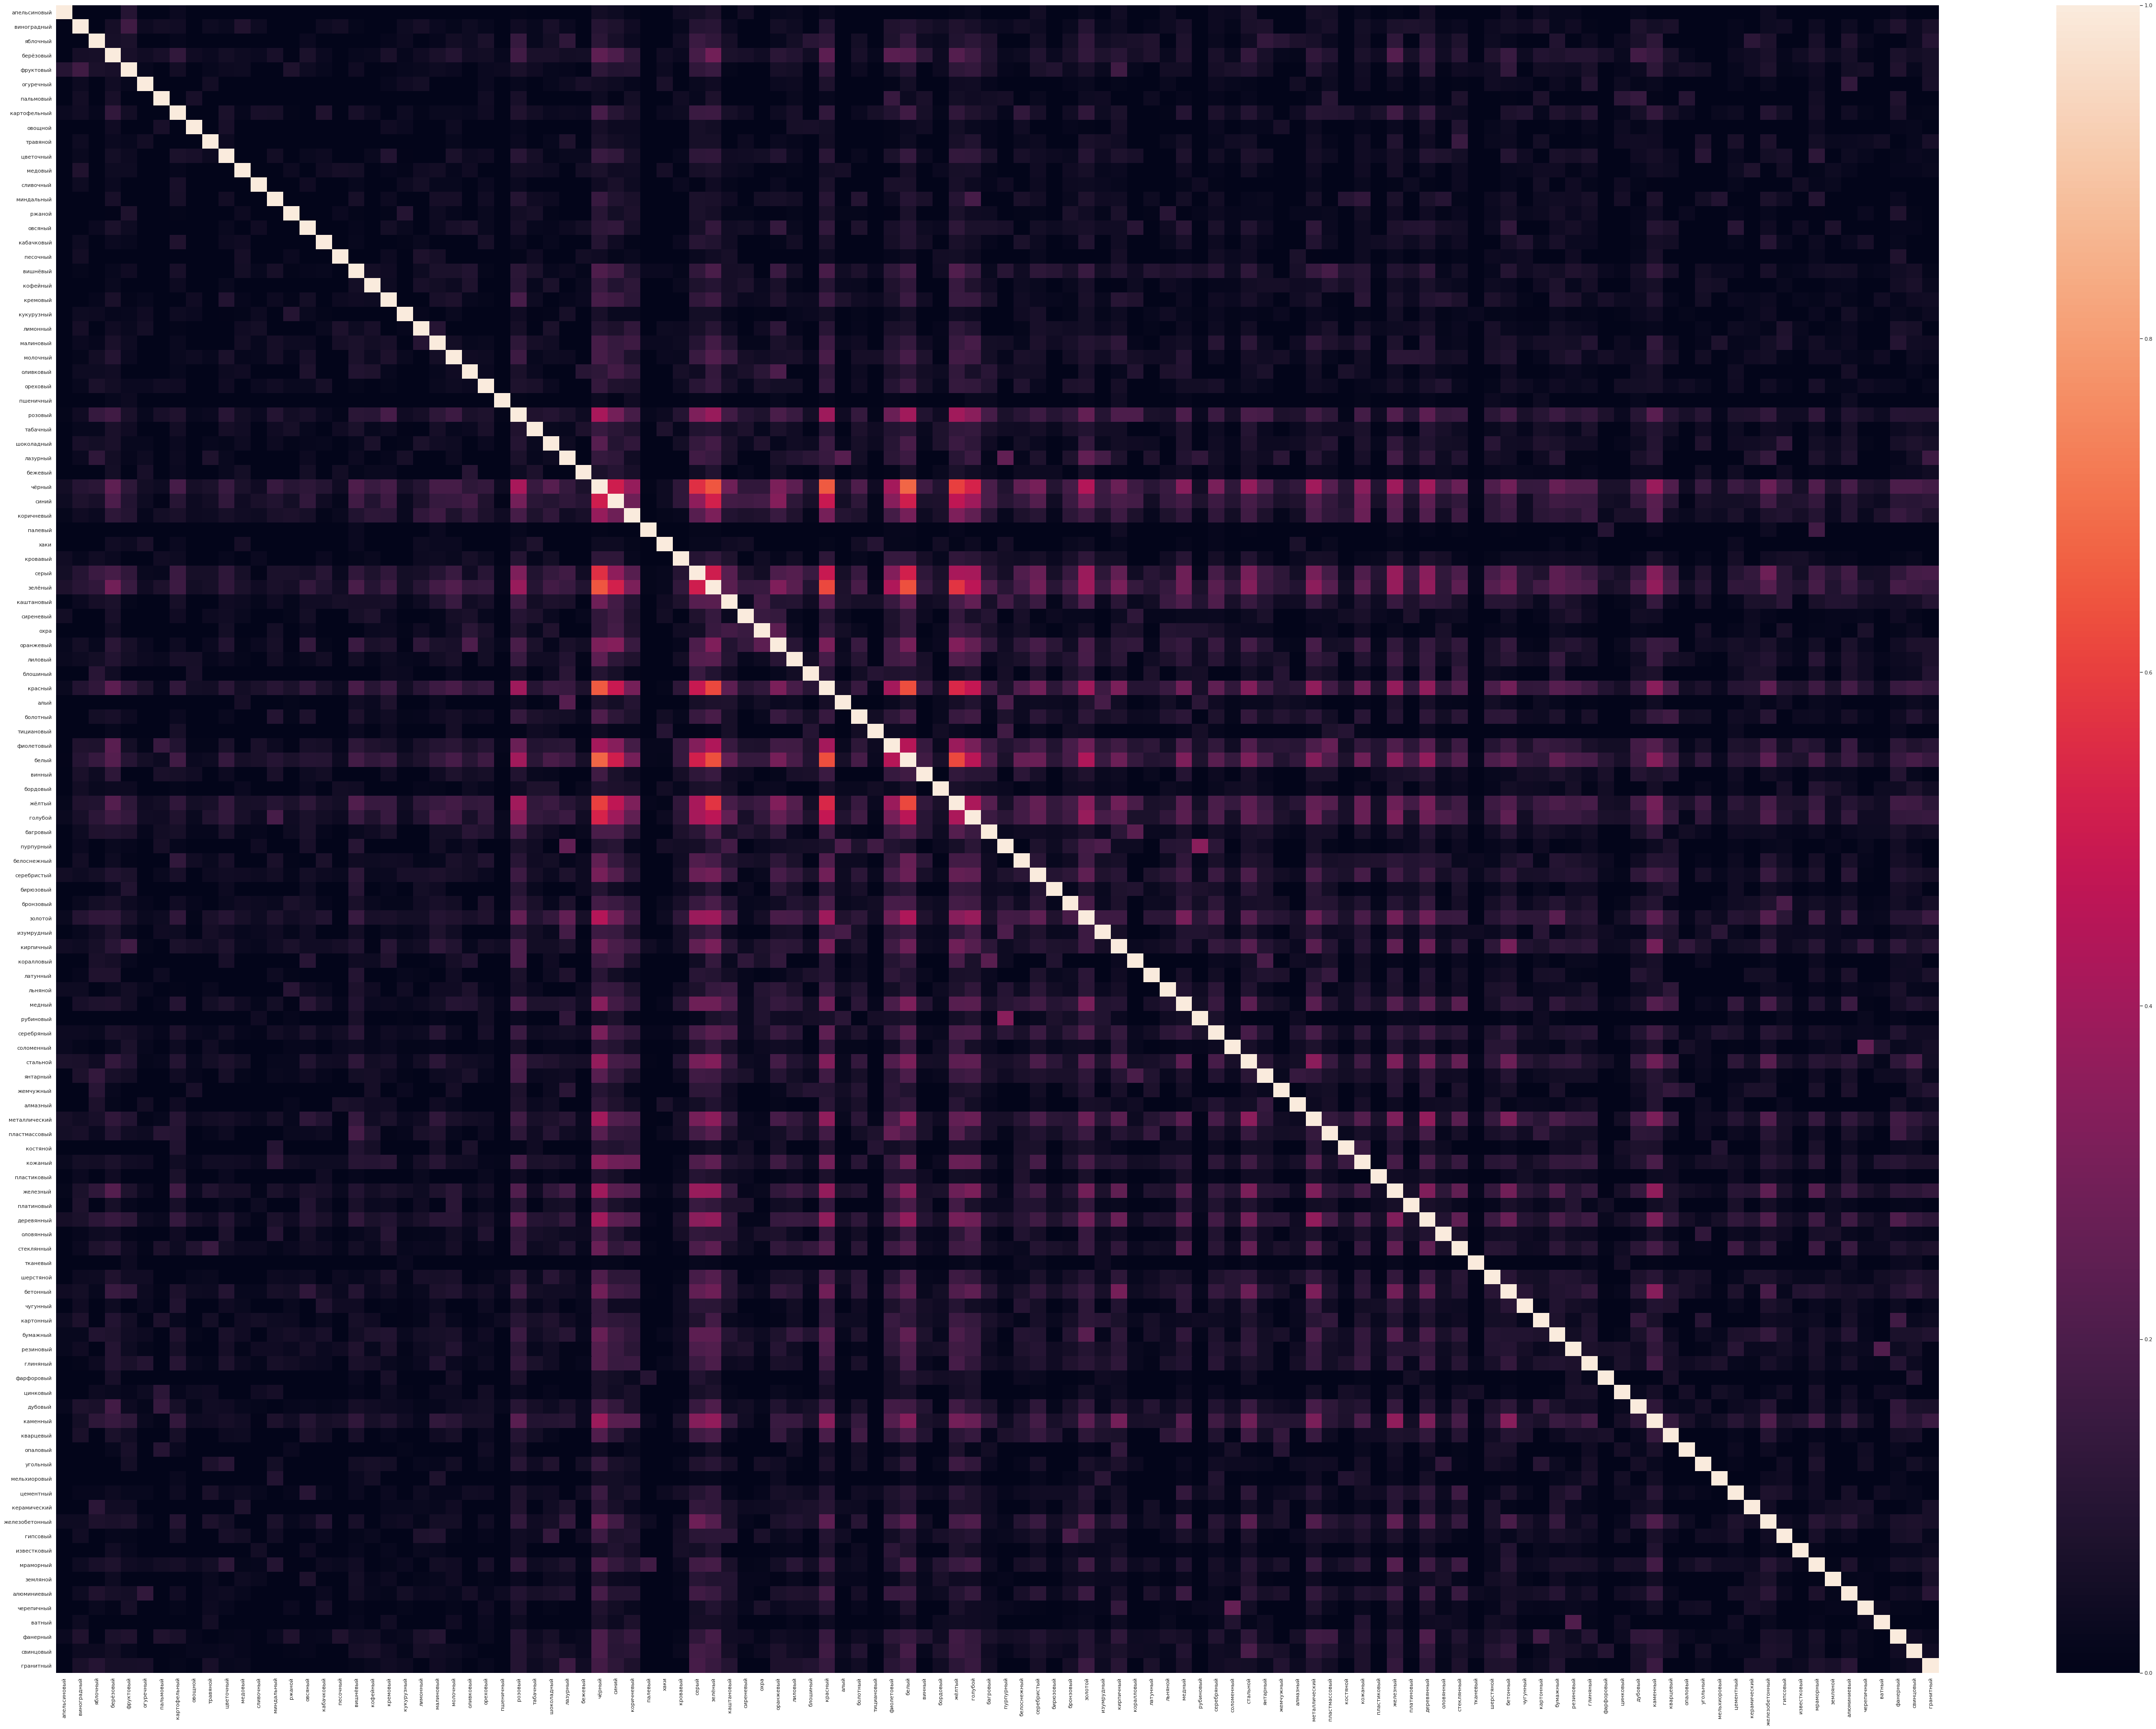

In [32]:
plt.figure(figsize=(88,64))
sns.heatmap(data=visual_matrix)
plt.show()

## distributional similarity heatmap, ordered by sum of similarity values


In [0]:
ordered_lists = []
for label in ['ing', 'ci', 'color', 'cm', 'material']:
  ordered_dict = {}
  for word in visual_list:
    if word[1] == label:
      ordered_dict[word[0]] = sum(visual_cosine_lists[word[0]])
  ordered_lists.extend(sorted(ordered_dict, key=lambda x: ordered_dict[x], reverse=True))

In [34]:
ordered_visual_lists = {}
for word in tqdm(ordered_lists):
  vec = []
  for i, other_word in enumerate(ordered_lists):
    val = visual_matrix[word][other_word]
    vec.append(val)
  ordered_visual_lists[word] = vec

100%|██████████| 116/116 [00:00<00:00, 470.58it/s]


In [0]:
ordered_matrix = pd.DataFrame(data=ordered_visual_lists, index=ordered_lists)

In [36]:
ordered_matrix.head()

,берёзовый,картофельный,фруктовый,цветочный,яблочный,овсяный,виноградный,миндальный,кабачковый,медовый,травяной,ржаной,пальмовый,огуречный,сливочный,овощной,апельсиновый,розовый,вишнёвый,молочный,малиновый,шоколадный,кремовый,табачный,ореховый,оливковый,кофейный,лимонный,кукурузный,песочный,пшеничный,чёрный,зелёный,белый,красный,жёлтый,серый,голубой,синий,фиолетовый,...,железный,каменный,металлический,бетонный,кожаный,стеклянный,железобетонный,бумажный,пластмассовый,мраморный,глиняный,дубовый,резиновый,фанерный,шерстяной,алюминиевый,свинцовый,кварцевый,гранитный,картонный,оловянный,цементный,платиновый,гипсовый,чугунный,жемчужный,угольный,керамический,алмазный,костяной,черепичный,цинковый,земляной,пластиковый,известковый,ватный,опаловый,фарфоровый,мельхиоровый,тканевый
берёзовый,1.000000,0.131036,0.065060,0.053495,0.059456,0.073544,0.054816,0.065779,0.031009,0.036772,0.031009,0.006672,0.065779,0.044348,0.031009,0.042460,0.000000,0.170434,0.020397,0.095746,0.070213,0.069338,0.070041,0.069338,0.048077,0.046513,0.024515,0.041437,0.016490,0.0,0.021926,0.245491,0.291673,0.221962,0.238696,0.219032,0.180683,0.164305,0.200907,0.230700,...,0.219849,0.144546,0.125318,0.150216,0.072636,0.105300,0.069770,0.081786,0.092450,0.079769,0.094783,0.175285,0.094969,0.073544,0.082245,0.059744,0.048058,0.073914,0.061340,0.092493,0.043374,0.035021,0.059456,0.018871,0.037062,0.021926,0.000000,0.046513,0.015504,0.000000,0.010223,0.025318,0.037827,0.040795,0.046513,0.0,0.021926,0.065779,0.000000,0.000000
картофельный,0.131036,1.000000,0.049257,0.072901,0.016205,0.000000,0.044821,0.059761,0.084515,0.016704,0.000000,0.009092,0.000000,0.000000,0.063387,0.000000,0.029881,0.082724,0.064859,0.026096,0.026096,0.028347,0.000000,0.047246,0.039311,0.021129,0.033408,0.011294,0.035956,0.0,0.000000,0.187052,0.160113,0.171197,0.130733,0.126894,0.152428,0.085205,0.102393,0.093335,...,0.168651,0.133253,0.102468,0.076035,0.045686,0.035875,0.095080,0.083592,0.094491,0.057977,0.104564,0.061249,0.058828,0.066815,0.000000,0.046524,0.009356,0.060437,0.013932,0.022917,0.039406,0.038180,0.064820,0.051434,0.088388,0.000000,0.000000,0.000000,0.042258,0.089642,0.013932,0.017252,0.000000,0.074125,0.000000,0.0,0.029881,0.000000,0.027277,0.000000
фруктовый,0.065060,0.049257,1.000000,0.032174,0.071520,0.036860,0.164845,0.000000,0.023313,0.036860,0.023313,0.080257,0.000000,0.022228,0.000000,0.000000,0.098907,0.070210,0.040893,0.028793,0.038391,0.020851,0.010532,0.039096,0.028916,0.000000,0.000000,0.024922,0.019836,0.0,0.032969,0.117617,0.150718,0.100819,0.134022,0.117735,0.127214,0.133365,0.090872,0.054201,...,0.078811,0.118260,0.090447,0.129067,0.046207,0.039583,0.081594,0.046116,0.043441,0.039981,0.067866,0.033790,0.038945,0.082936,0.044969,0.051333,0.020646,0.044455,0.061488,0.050572,0.010870,0.021063,0.017880,0.014188,0.000000,0.000000,0.053640,0.046625,0.000000,0.000000,0.061488,0.019035,0.000000,0.000000,0.023313,0.0,0.065938,0.000000,0.000000,0.032969
цветочный,0.053495,0.072901,0.032174,1.000000,0.000000,0.027277,0.024398,0.048795,0.034503,0.000000,0.034503,0.000000,0.000000,0.000000,0.000000,0.062994,0.000000,0.109109,0.000000,0.071024,0.000000,0.015430,0.093522,0.057864,0.042796,0.034503,0.027277,0.000000,0.007339,0.0,0.000000,0.148895,0.127989,0.144070,0.110945,0.134221,0.121265,0.132667,0.130858,0.072197,...,0.058321,0.056766,0.055776,0.095511,0.043519,0.051260,0.051755,0.068252,0.038576,0.118345,0.080354,0.040008,0.057639,0.013639,0.000000,0.037987,0.030557,0.032898,0.022751,0.000000,0.080436,0.031174,0.026463,0.062994,0.041239,0.000000,0.105851,0.000000,0.000000,0.000000,0.022751,0.000000,0.000000,0.030261,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
яблочный,0.059456,0.016205,0.071520,0.000000,1.000000,0.030317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144366,0.000000,0.047363,0.015788,0.051450,0.017324,0.021437,0.071348,0.038348,0.000000,0.000000,0.032629,0.0,0.000000,0.110731,0.128027,0.142968,0.127045,0.

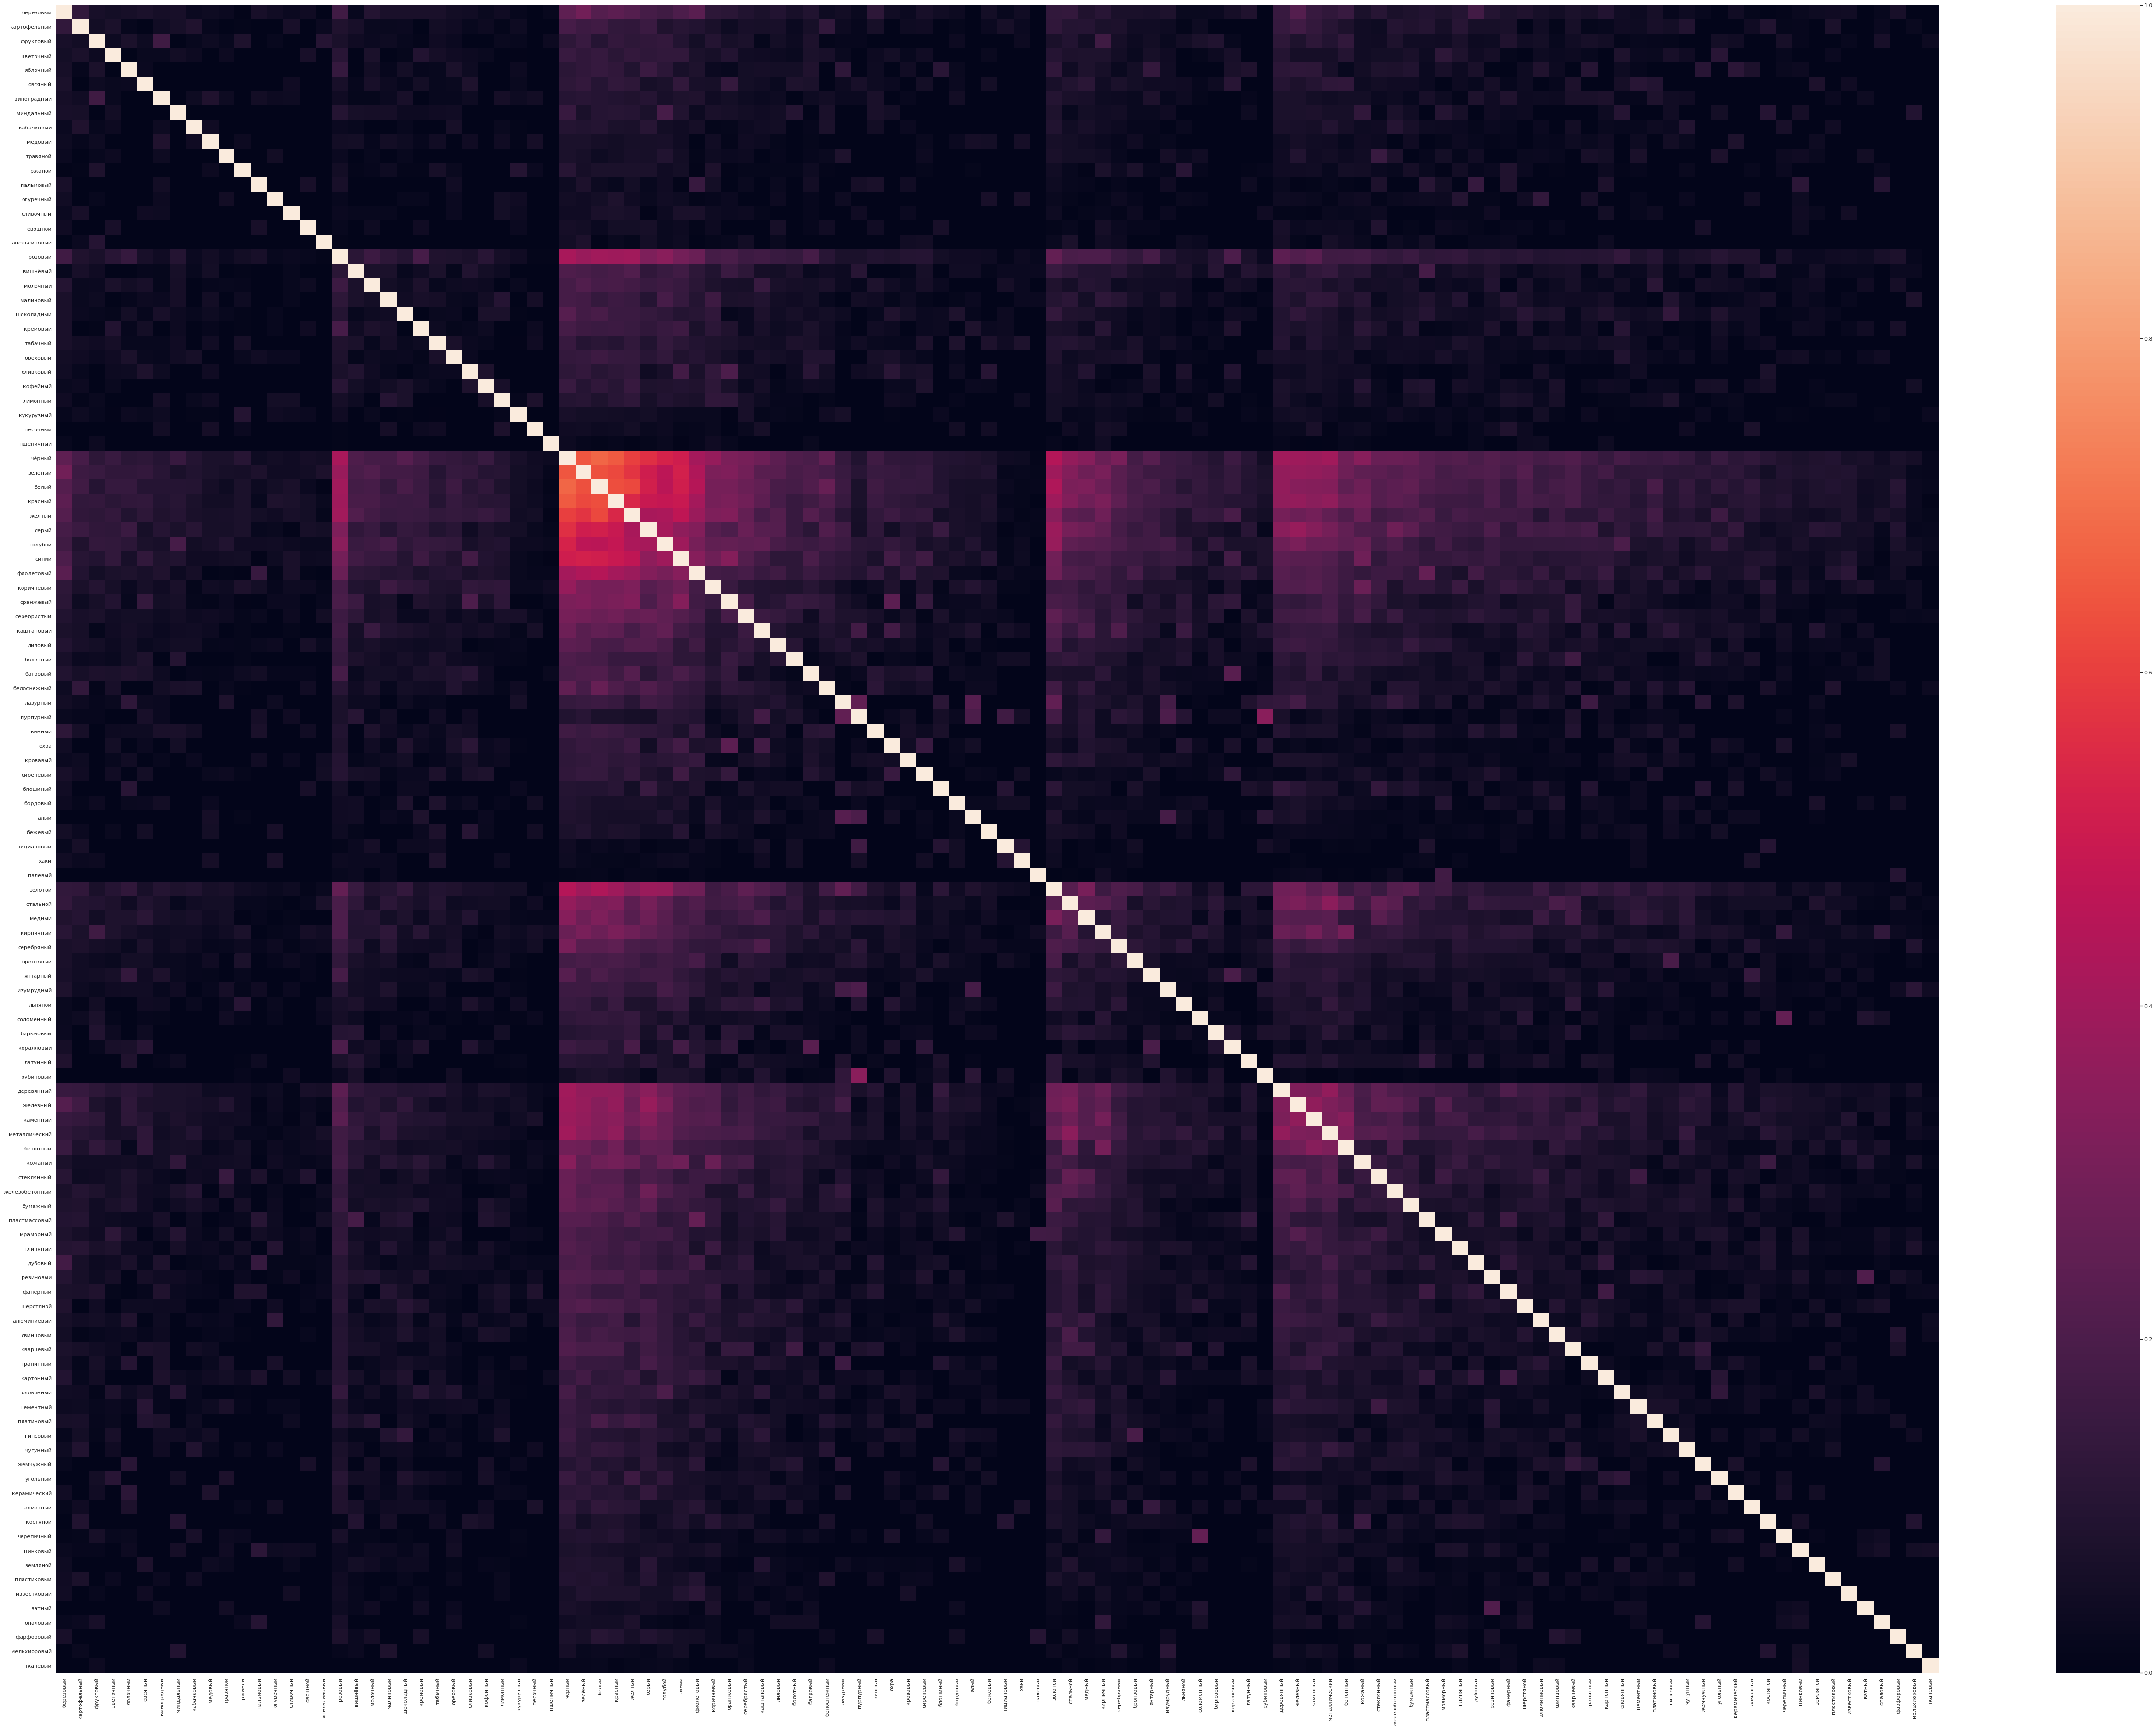

In [37]:
plt.figure(figsize=(88,64))
sns.heatmap(data=ordered_matrix)
plt.show()

## distributional similarity heatmap, ordered by corpus frequency

In [0]:
byfreq_lists = []
for label in ['ing', 'ci', 'color', 'cm', 'material']:
  ordered_dict = {}
  for word in visual_list:
    if word[1] == label and lemma_count[word[0]] > 7:
      ordered_dict[word[0]] = lemma_count[word[0]]
  byfreq_lists.extend(sorted(ordered_dict, key=lambda x: ordered_dict[x], reverse=True))

In [40]:
for word in byfreq_lists:
  print(word, lemma_count[word], sep=';')

берёзовый;15
картофельный;10
фруктовый;8
розовый;58
кукурузный;11
молочный;11
вишнёвый;10
малиновый;9
кремовый;8
шоколадный;8
чёрный;425
красный;251
зелёный;230
белый;209
жёлтый;150
голубой;101
серый;99
синий;79
коричневый;38
фиолетовый;25
оранжевый;17
каштановый;15
лиловый;15
серебристый;15
багровый;14
золотой;73
стальной;57
кирпичный;47
серебряный;30
медный;23
бронзовый;12
янтарный;10
соломенный;9
металлический;101
железный;101
деревянный;88
бетонный;63
каменный;60
кожаный;37
стеклянный;25
глиняный;19
дубовый;19
резиновый;18
бумажный;16
мраморный;14
пластмассовый;12
фанерный;10
свинцовый;10
цементный;9
шерстяной;8


In [70]:
try:
  for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)
except Exception:
  pass

byfreq_visual_lists = {}
for word in tqdm(byfreq_lists):
  vec = []
  for i, other_word in enumerate(byfreq_lists):
    val = cosine(vec_dic[word], vec_dic[other_word])
    vec.append(val)
  byfreq_visual_lists[word] = vec

100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


In [0]:
byfreq_matrix = pd.DataFrame(data=byfreq_visual_lists, index=byfreq_lists)

In [72]:
byfreq_matrix.head()

,берёзовый,картофельный,фруктовый,розовый,кукурузный,молочный,вишнёвый,малиновый,кремовый,шоколадный,чёрный,красный,зелёный,белый,жёлтый,голубой,серый,синий,коричневый,фиолетовый,оранжевый,каштановый,лиловый,серебристый,багровый,золотой,стальной,кирпичный,серебряный,медный,бронзовый,янтарный,соломенный,металлический,железный,деревянный,бетонный,каменный,кожаный,стеклянный,глиняный,дубовый,резиновый,бумажный,мраморный,пластмассовый,фанерный,свинцовый,цементный,шерстяной
берёзовый,0.000000,0.868964,0.934940,0.829566,0.983510,0.904254,0.979603,0.929787,0.929959,0.930662,0.754509,0.761304,0.708327,0.778038,0.780968,0.835695,0.819317,0.799093,0.879437,0.769300,0.887638,0.928088,0.907486,0.911650,0.911177,0.868286,0.865348,0.891435,0.933290,0.916212,0.930867,0.933806,0.973061,0.874682,0.780151,0.854452,0.849784,0.855454,0.927364,0.894700,0.905217,0.824715,0.905031,0.918214,0.920231,0.907550,0.926456,0.951942,0.964979,0.917755
картофельный,0.868964,0.000000,0.950743,0.917276,0.964044,0.973904,0.935141,0.973904,1.000000,0.971653,0.812948,0.869267,0.839887,0.828803,0.873106,0.914795,0.847572,0.897607,0.931876,0.906665,0.963250,0.938751,0.936963,0.936258,0.939477,0.871406,0.905086,0.927669,0.923444,0.902128,0.956517,0.954896,0.963289,0.897532,0.831349,0.857286,0.923965,0.866747,0.954314,0.964125,0.895436,0.938751,0.941172,0.916408,0.942023,0.905509,0.933185,0.990644,0.961820,1.000000
фруктовый,0.934940,0.950743,0.000000,0.929790,0.980164,0.971207,0.959107,0.961609,0.989468,0.979149,0.882383,0.865978,0.849282,0.899181,0.882265,0.866635,0.872786,0.909128,0.902727,0.945799,0.939178,0.986484,0.945904,0.929670,0.924875,0.932013,0.909239,0.833132,0.941928,0.952005,0.968015,0.950234,0.929116,0.909553,0.921189,0.882569,0.870933,0.881740,0.953793,0.960417,0.932134,0.966210,0.961055,0.953884,0.960019,0.956559,0.917064,0.979354,0.978937,0.955031
розовый,0.829566,0.917276,0.929790,0.000000,0.959960,0.841913,0.887739,0.879110,0.816327,0.902352,0.582865,0.606767,0.618962,0.601403,0.597657,0.654008,0.682453,0.704133,0.818644,0.726920,0.807930,0.829756,0.847749,0.841000,0.816679,0.745102,0.804957,0.797315,0.846547,0.800428,0.870875,0.817843,0.944402,0.834469,0.785767,0.761236,0.829093,0.768771,0.820919,0.854583,0.866297,0.897417,0.888895,0.846097,0.873457,0.879343,0.901786,0.903314,0.921769,0.887442
кукурузный,0.983510,0.964044,0.980164,0.959960,0.000000,0.973728,1.000000,1.000000,1.000000,0.990487,0.936890,0.951291,0.947020,0.947659,0.953544,0.967084,0.947863,0.975349,0.975793,0.975272,0.993834,0.987667,0.978845,0.935827,0.996192,0.948754,0.980889,0.963590,0.971097,0.978103,0.985408,0.988648,0.990760,0.969052,0.947065,0.953730,0.986751,0.953337,0.986585,0.977427,0.984519,0.972251,0.991116,0.975454,0.970815,0.984145,0.974775,0.985871,1.000000,0.989742


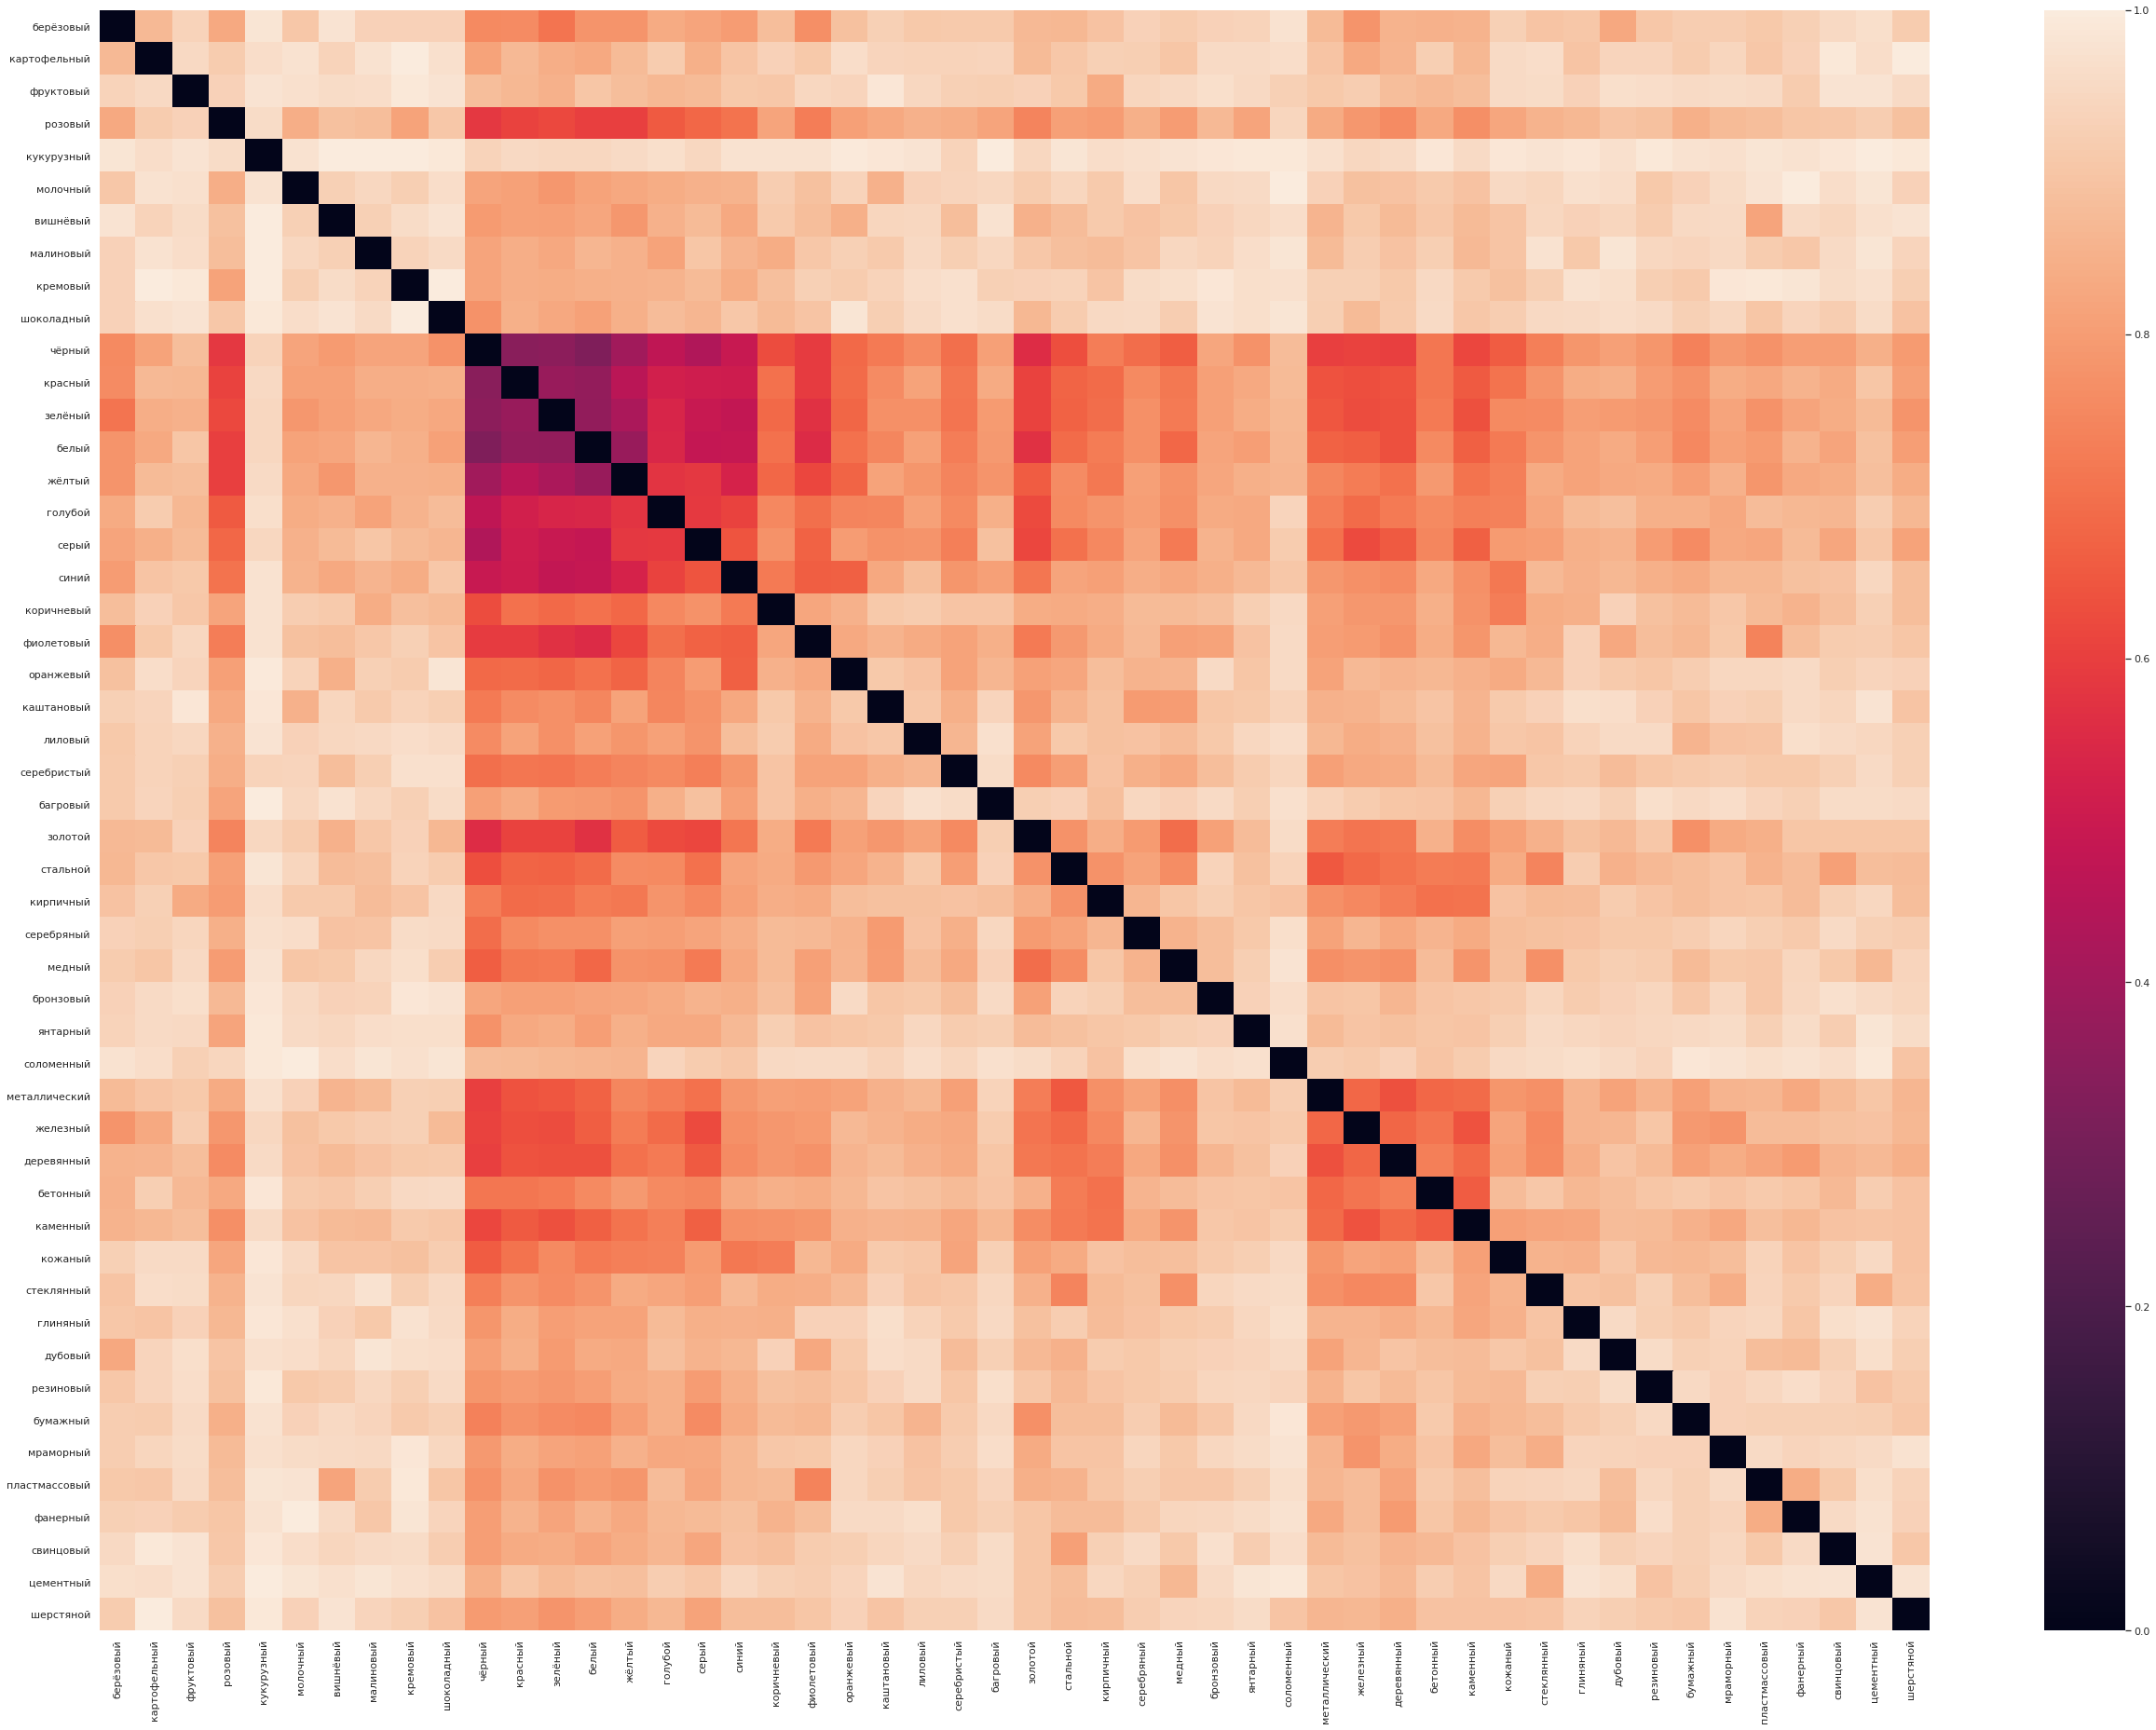

In [82]:
plt.figure(figsize=(44,32))
sns.heatmap(data=byfreq_matrix)
plt.show()

## hierarchical clustering

In [0]:
from scipy.cluster.hierarchy import linkage, dendrogram

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


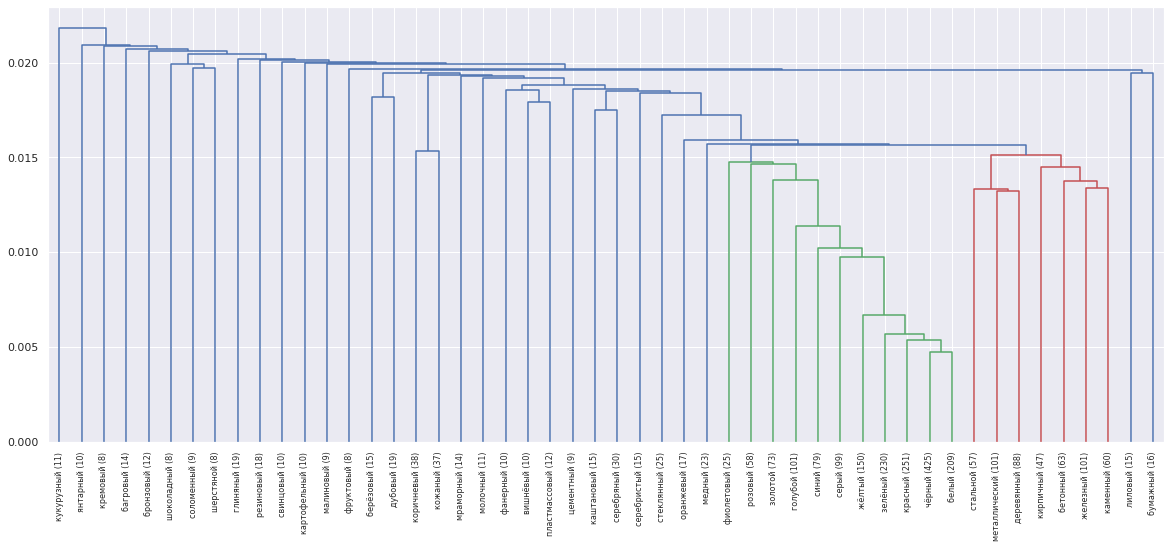

In [81]:
linkage_data = linkage(y=byfreq_matrix, metric='cosine') # method=single
plt.figure(figsize=(20,8))
dendrogram(linkage_data, labels=[word + ' ({})'.format(lemma_count[word]) for word in byfreq_matrix.index])
plt.show()